### Porto Seguro 

3rd Largest Insurance Company in Brasil

---

__Goal__ - To produce the likelyhood a driver will initiate an insurance claim.

__Notes__ 
- Though this is an insurance claim problem, the data is anonomyzed in such a way that no features are known. Therefore, there is no 'domain expertise' easily used to construct features unless there is a labeled dataset somewhere you could compare.
- Classes are highly imbalanced


In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *
import itertools
#import fancyimpute

%matplotlib inline

In [438]:
test = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

Get aquainted with dataset

In [436]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 63 columns):
id                   595212 non-null int64
target               595212 non-null int64
ps_ind_02_cat        595212 non-null int64
ps_ind_04_cat        595212 non-null int64
ps_ind_05_cat        595212 non-null int64
ps_ind_06_bin        595212 non-null int64
ps_ind_07_bin        595212 non-null int64
ps_ind_08_bin        595212 non-null int64
ps_ind_09_bin        595212 non-null int64
ps_ind_10_bin        595212 non-null int64
ps_ind_11_bin        595212 non-null int64
ps_ind_12_bin        595212 non-null int64
ps_ind_13_bin        595212 non-null int64
ps_ind_16_bin        595212 non-null int64
ps_ind_17_bin        595212 non-null int64
ps_ind_18_bin        595212 non-null int64
ps_reg_01            595212 non-null float64
ps_reg_02            595212 non-null float64
ps_reg_03            595212 non-null float64
ps_car_01_cat        595212 non-null int64
ps_car_02_cat        59

In [439]:
train.shape

(595212, 59)

In [440]:
test.shape

(892816, 58)

Target variable is unbalanced. Looking for combinations of variables that produce predictive power above .036

In [441]:
train['target'].value_counts()/train['target'].count()

0    0.963552
1    0.036448
Name: target, dtype: float64

Similar features in 4 categories: 

    ind, reg, car, calc.

Feature types:

    bin = binary, cat = categorical, unspecified = continuous or ordinal

In [442]:
cat_cols = []
bin_cols = []
ord_cont_cols = []
for col in train.columns:
    if 'cat' in col:
        cat_cols.append(col)
    elif 'bin' in col:
        bin_cols.append(col)
    elif 'target' in col or 'id' in col:
        pass
    else:
        ord_cont_cols.append(col)

In [443]:
data_groups = [cat_cols,bin_cols,ord_cont_cols]

In [444]:
for group in data_groups:
    print(len(group))

14
17
26


In [445]:
cont_cols = []
ord_cols = []

for col in ord_cont_cols:
    if train[col].dtype == 'int64':
        #print(col)
        train['{}_ord'.format(col)] = train[col]
        train.drop(col,axis=1,inplace=True)
        ord_cols.append('{}_ord'.format(col))
    else:
        cont_cols.append(col)

In [446]:
ind_cols = []
reg_cols = []
car_cols = []
calc_cols = []
for col in train.columns:
    if 'ind' in col:
        ind_cols.append(col)
    if 'reg' in col:
        reg_cols.append(col)
    if 'car' in col:
        car_cols.append(col)
    if 'calc' in col:
        calc_cols.append(col)

In [447]:
type_groups = [ind_cols, reg_cols, car_cols, calc_cols]

In [448]:
for group in type_groups:
    print(len(group))

18
3
16
20


All columns accounted for

In [449]:
train.drop(cat_cols + bin_cols + ord_cols + cont_cols,axis=1).head(1)

,id,target
0,7,0


In [450]:
train.drop(ind_cols + reg_cols + car_cols + calc_cols, axis=1).head(1)

,id,target
0,7,0


NaNs are -1's, but it doesn't seem beneficial to impute these as of yet. Non-filled outscored filled in testing

In [154]:
train_spare = train.copy()

In [156]:
train_na = train.replace(-1,np.NaN)

In [157]:
null_cols = []
for col in train_na.columns:
    if train_na[col].isnull().sum() > 0:
        null_cols.append(col)
        print('{}\t\t\t{} nulls'.format(col,train_na[col].isnull().sum()))

ps_ind_02_cat			216 nulls
ps_ind_04_cat			83 nulls
ps_ind_05_cat			5809 nulls
ps_reg_03			107772 nulls
ps_car_01_cat			107 nulls
ps_car_02_cat			5 nulls
ps_car_03_cat			411231 nulls
ps_car_05_cat			266551 nulls
ps_car_07_cat			11489 nulls
ps_car_09_cat			569 nulls
ps_car_12			1 nulls
ps_car_14			42620 nulls
ps_car_11_ord			5 nulls


Drop above 30% null

In [451]:
high_null_cols = [col for col in train_na.columns[train_na.isnull().sum()/train_na.shape[0] > .3]]

train_na = train_na.drop(high_null_cols,axis=1)

Drop calc cols

In [453]:
calc_cols = [col for col in train_na.columns[train_na.columns.str.contains('calc')]]

train_na = train_na.drop(calc_cols,axis=1)

Impute bin and cat with median

In [162]:
bin_cols = [col for col in train_na.columns[train_na.columns.str.contains('bin')]]
cat_cols = [col for col in train_na.columns[train_na.columns.str.contains('cat')]]
ord_cols = [col for col in train_na.columns[train_na.columns.str.contains('ord')]]

In [163]:
bin_cat_train_na = train_na[bin_cols+cat_cols+ord_cols]

In [164]:
from fancyimpute import SimpleFill
bin_cat_train_na_cols = bin_cat_train_na.columns
bin_cat_train_na = pd.DataFrame(SimpleFill(fill_method='median').complete(bin_cat_train_na.as_matrix()),columns=bin_cat_train_na_cols)

Impute cont with mean

In [165]:
cont_train_na = train_na.drop(bin_cols+cat_cols+ord_cols,axis=1)

In [166]:
from fancyimpute import SimpleFill
cont_train_na_cols = cont_train_na.columns
cont_train_na = pd.DataFrame(SimpleFill().complete(cont_train_na.as_matrix()),columns=cont_train_na_cols)

Reconnect these

In [195]:
train_na_mean = pd.concat([cont_train_na,bin_cat_train_na],axis=1)

Invetigate categorical

In [228]:
for col in reg_cols:
    print(train_na_mean.groupby(col)['target'].describe().unstack()[['count','mean']])#.unstack())

              count      mean
ps_reg_01                    
0.0         21682.0  0.039249
0.1         43192.0  0.023824
0.2         25113.0  0.027317
0.3         40290.0  0.031919
0.4         53569.0  0.034498
0.5         32341.0  0.031168
0.6         56243.0  0.036182
0.7         67897.0  0.038617
0.8         60277.0  0.038555
0.9        194608.0  0.041134
              count      mean
ps_reg_02                    
0.0         89297.0  0.033775
0.1         31816.0  0.024296
0.2        114886.0  0.029003
0.3         95033.0  0.033757
0.4         59746.0  0.036521
0.5         36528.0  0.039312
0.6         33474.0  0.042929
0.7         21210.0  0.042527
0.8         19907.0  0.044406
0.9         16788.0  0.046938
1.0         12570.0  0.042641
1.1         11321.0  0.045402
1.2         15843.0  0.050369
1.3         11761.0  0.048550
1.4          6877.0  0.047841
1.5          5845.0  0.044996
1.6          5095.0  0.056330
1.7          2478.0  0.056497
1.8          4737.0  0.062909
          

In [454]:
train.groupby(['ps_ind_01_ord'])['target'].describe().unstack()[['count','mean']]

,count,mean
ps_ind_01_ord,,
0,187594.0,0.033221
1,143984.0,0.033629
2,82468.0,0.036863
3,51193.0,0.040963
4,33524.0,0.045132
5,61464.0,0.040316
6,17682.0,0.043151
7,17303.0,0.042131


In [432]:
train.groupby(['ps_ind_01_ord'])['target'].agg({'sum' : 'sum', 'count' : 'count', 'mean' : 'mean'})#.describe().unstack()#[['count','mean']]

,sum,count,mean
ps_ind_01_ord,,,
0,6232,187594,0.033221
1,4842,143984,0.033629
2,3040,82468,0.036863
3,2097,51193,0.040963
4,1513,33524,0.045132
5,2478,61464,0.040316
6,763,17682,0.043151
7,729,17303,0.042131


Take a look at the average outcome for each value within null_cols

In [456]:
for col in null_cols:
#    train.groupby([col])['target'].describe().unstack()[['mean']].plot()
    print(train.groupby([col])['target'].describe().unstack()[['count','mean']])

                  count      mean
ps_ind_02_cat                    
-1                216.0  0.185185
 1             431859.0  0.035725
 2             123573.0  0.038139
 3              28186.0  0.037217
 4              11378.0  0.040780
                  count      mean
ps_ind_04_cat                    
-1                 83.0  0.397590
 0             346965.0  0.034790
 1             248164.0  0.038644
                  count      mean
ps_ind_05_cat                    
-1               5809.0  0.083319
 0             528009.0  0.033865
 1               8322.0  0.047825
 2               4184.0  0.075526
 3               8233.0  0.042998
 4              18344.0  0.052061
 5               1649.0  0.048514
 6              20662.0  0.059336
              count      mean
ps_reg_03                    
-1.000000  107772.0  0.028393
 0.061237       3.0  0.000000
 0.075000      22.0  0.000000
 0.132288       1.0  0.000000
 0.136931       2.0  0.000000
 0.150000       3.0  0.000000
 0.154110   

In [312]:
train['ps_car_12'] ** 2

0         0.1600
1         0.1000
2         0.1000
3         0.1400
4         0.0999
5         0.1989
6         0.1000
7         0.1998
8         0.1600
9         0.2000
10        0.2000
11        0.1400
12        0.1400
13        0.1600
14        0.1000
15        0.3000
16        0.1000
17        0.1000
18        0.1600
19        0.0994
20        0.0999
21        0.1000
22        0.2000
23        0.1600
24        0.1800
25        0.2800
26        0.2000
27        0.1000
28        0.2000
29        0.1400
           ...  
595182    0.1000
595183    0.1000
595184    0.1400
595185    0.1000
595186    0.1000
595187    0.1400
595188    0.1000
595189    0.1400
595190    0.0999
595191    0.1600
595192    0.1000
595193    0.1600
595194    0.1400
595195    0.1400
595196    0.1400
595197    0.1600
595198    0.1400
595199    0.1800
595200    0.1600
595201    0.1000
595202    0.2000
595203    0.1600
595204    0.1400
595205    0.1400
595206    0.2000
595207    0.1400
595208    0.1500
595209    0.15

In [308]:
train.groupby(['ps_car_12'])['target'].describe().unstack()[['mean']]

,mean
ps_car_12,
-1.000000,0.000000
0.100000,0.000000
0.141421,0.056604
0.148324,0.000000
0.173205,0.000000
0.282843,0.000000
0.308869,0.000000
0.315278,0.021981
0.315595,0.018101


ps_car_09_cat

In [ ]:
ps_car_09_cat_mappings = {}
ps_car_09_cat_mappings[4] = 1
ps_car_09_cat_mappings[3] = 1
ps_car_09_cat_mappings[2] = 1
ps_car_09_cat_mappings[1] = 1
ps_car_09_cat_mappings[0] = 0
ps_car_09_cat_mappings[-1] = 1

ps_car_07_cat

In [302]:
ps_car_07_cat_mappings = {}
ps_car_07_cat_mappings[1] = 0
ps_car_07_cat_mappings[0] = 1
ps_car_07_cat_mappings[-1] = 1

ps_car_05_cat

In [301]:
ps_car_05_cat_mappings = {}
ps_car_05_cat_mappings[1] = 1
ps_car_05_cat_mappings[0] = 1
ps_car_05_cat_mappings[-1] = 0

In [ ]:
train['ps_car_05_cat_bin'] = train['ps_car_05_cat'].replace(ps_car_03_cat_mappings)

ps_car_03_cat

In [292]:
ps_car_03_cat_mappings = {}
ps_car_03_cat_mappings[1] = 1
ps_car_03_cat_mappings[0] = 1
ps_car_03_cat_mappings[-1] = 0

In [293]:
train['ps_car_03_cat_bin'] = train['ps_car_03_cat'].map(ps_car_03_cat_mappings)

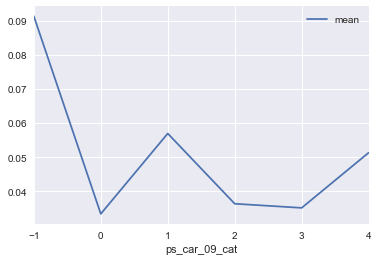

In [287]:
train.groupby(['ps_car_09_cat'])['target'].describe().unstack()[['mean']].plot()

In [318]:
train['ps_reg_03']

0         0.718070
1         0.766078
2        -1.000000
3         0.580948
4         0.840759
5         2.332649
6         0.617454
7         0.607248
8         0.901388
9         2.316652
10        0.795692
11        0.378319
12        0.548293
13        0.684197
14        1.052972
15       -1.000000
16        0.699553
17        0.810864
18       -1.000000
19        0.402337
20        1.372725
21        0.955903
22        0.742041
23       -1.000000
24        0.587367
25       -1.000000
26        0.666146
27        1.034408
28       -1.000000
29        1.155692
            ...   
595182    0.941077
595183    0.953612
595184    0.626997
595185    0.500000
595186    1.006231
595187    0.910014
595188   -1.000000
595189    0.808934
595190   -1.000000
595191    0.912414
595192    0.649519
595193    1.362213
595194   -1.000000
595195    0.629980
595196    0.852936
595197    1.332291
595198    0.839643
595199    0.779022
595200    0.392110
595201    0.812404
595202    0.366572
595203    1.

In [328]:
train.groupby(['ps_reg_03'])['target'].describe().unstack()[['count']].median()

count    49.0
dtype: float64

In [334]:
train['ps_reg_03_mean'] = (train.groupby(['ps_reg_03'])['target'].describe().unstack()[['mean']] > .05).astype(np.int)

In [333]:
train['ps_reg_03_count'] = (train.groupby(['ps_reg_03'])['target'].describe().unstack()[['count']] > 10).astype(np.int)

In [336]:
train['ps_reg_03_mean']

0         NaN
1         0.0
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        NaN
         ... 
595182    NaN
595183    NaN
595184    NaN
595185    NaN
595186    NaN
595187    NaN
595188    NaN
595189    NaN
595190    NaN
595191    NaN
595192    NaN
595193    NaN
595194    NaN
595195    NaN
595196    NaN
595197    NaN
595198    NaN
595199    NaN
595200    NaN
595201    NaN
595202    NaN
595203    NaN
595204    NaN
595205    NaN
595206    NaN
595207    NaN
595208    NaN
595209    NaN
595210    NaN
595211    NaN
Name: ps_reg_03_mean, dtype: float64

In [ ]:
train['ps_reg_03_bin'] = 

In [326]:
train.groupby(['ps_reg_03'])['target'].describe().unstack()[['count','mean']].sort_values(by='mean',ascending=False)
 
 #> .05).astype(np.int).unstack().unstack()

,count,mean
ps_reg_03,,
1.768651,2.0,1.000000
1.695398,1.0,1.000000
1.397542,2.0,1.000000
1.326885,1.0,1.000000
1.518017,1.0,1.000000
1.351157,1.0,1.000000
1.783080,1.0,1.000000
2.486715,1.0,1.000000
1.514100,5.0,0.600000


In [337]:
mean_mappings = (train.groupby(['ps_reg_03'])['target'].describe()
            .unstack()[['mean']] > .05).astype(np.int).unstack().unstack()

ps_reg_03_mean_mappings = {}
for val in mean_mappings.columns:
    ps_reg_03_mean_mappings[val] = mean_mappings[val]['mean']

train['ps_reg_03_mean'] = train['ps_reg_03'].map(ps_reg_03_mean_mappings)

count_mappings = (train.groupby(['ps_reg_03'])['target'].describe()
            .unstack()[['count']] > 30).astype(np.int).unstack().unstack()

ps_reg_03_count_mappings = {}
for val in count_mappings.columns:
    ps_reg_03_count_mappings[val] = count_mappings[val]['count']

train['ps_reg_03_count'] = train['ps_reg_03'].map(ps_reg_03_count_mappings)

In [384]:
train['ps_reg_03_count'].value_counts()

1    569856
0     25356
Name: ps_reg_03_count, dtype: int64

In [387]:
def reg_03(row):
    if row['ps_reg_03_count'] == 1 and row['ps_reg_03_mean'] == 1:
        return 1
    else:
        return 0

train['ps_reg_03_bin'] = train.apply(reg_03,axis=1)

In [395]:
train['ps_reg_03']

0         0.718070
1         0.766078
2        -1.000000
3         0.580948
4         0.840759
5         2.332649
6         0.617454
7         0.607248
8         0.901388
9         2.316652
10        0.795692
11        0.378319
12        0.548293
13        0.684197
14        1.052972
15       -1.000000
16        0.699553
17        0.810864
18       -1.000000
19        0.402337
20        1.372725
21        0.955903
22        0.742041
23       -1.000000
24        0.587367
25       -1.000000
26        0.666146
27        1.034408
28       -1.000000
29        1.155692
            ...   
595182    0.941077
595183    0.953612
595184    0.626997
595185    0.500000
595186    1.006231
595187    0.910014
595188   -1.000000
595189    0.808934
595190   -1.000000
595191    0.912414
595192    0.649519
595193    1.362213
595194   -1.000000
595195    0.629980
595196    0.852936
595197    1.332291
595198    0.839643
595199    0.779022
595200    0.392110
595201    0.812404
595202    0.366572
595203    1.

ps_ind_02_cat
ps_ind_04_cat
ps_ind_05_cat
ps_car_01_cat
ps_car_02_cat
ps_car_04_cat
ps_car_06_cat
ps_car_07_cat
ps_car_08_cat
ps_car_09_cat
ps_car_10_cat
ps_car_11_cat


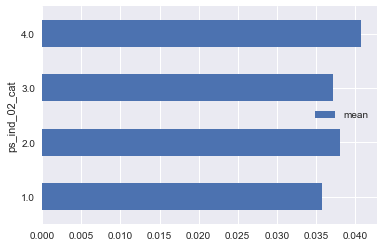

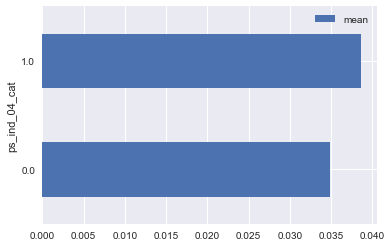

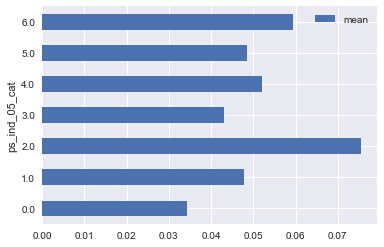

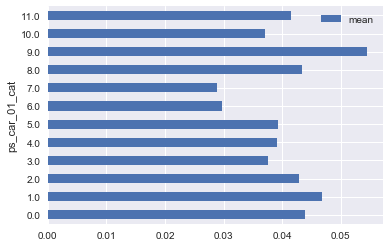

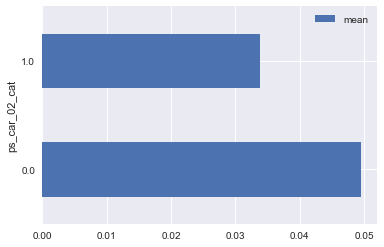

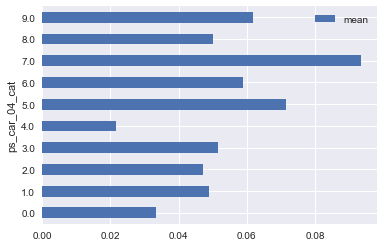

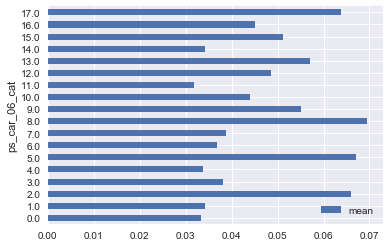

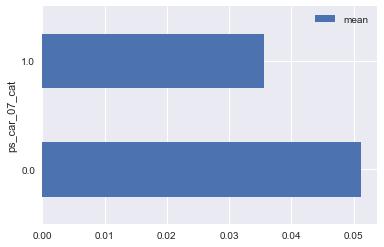

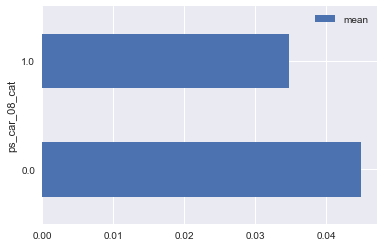

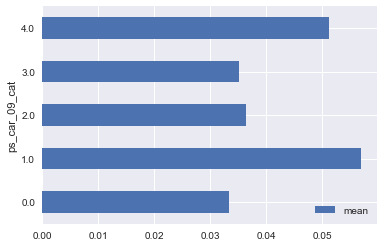

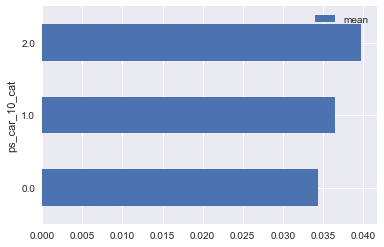

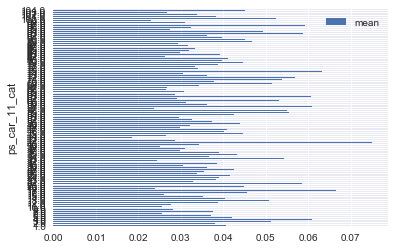

In [214]:
for col in cat_cols:
    print(col)
    train_na_mean.groupby(col)['target'].describe().unstack()[['mean']].plot(kind='barh')

Create one hot columns for all categorical. Difficult to align with test dataset due to unseen data in test.

In [168]:
def create_onehot(train):
    onehot_cols = []
    for col in [col for col in train.columns[train.columns.str.contains('cat')]]:
        onehot = pd.get_dummies(train[col],prefix=col,dummy_na=np.NaN)
        for new_col in onehot.columns:
            onehot_cols.append(new_col)
        train.drop(col,axis=1,inplace=True)
        train = pd.concat([train,onehot],axis=1)
    return train

In [112]:
#train_na_mean_imputed = create_onehot(train_na_mean_imputed)

In [169]:
[col for col in train_na_mean_imputed.columns[train_na_mean_imputed.columns.str.contains('cat')]]

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

Create function to transform

In [170]:
def transform_df(train):
    train_na = train.replace(-1,np.NaN)
    
    calc_cols = [col for col in train_na.columns[train_na.columns.str.contains('calc')]]
    train_na = train_na.drop(calc_cols,axis=1)
    
    bin_cols = [col for col in train_na.columns[train_na.columns.str.contains('bin')]]
    cat_cols = [col for col in train_na.columns[train_na.columns.str.contains('cat')]]
    ord_cols = [col for col in train_na.columns[train_na.columns.str.contains('ord')]]
    
    bin_cat_train_na = train_na[bin_cols+cat_cols+ord_cols]    
    from fancyimpute import SimpleFill
    bin_cat_train_na_cols = bin_cat_train_na.columns
    bin_cat_train_na = pd.DataFrame(SimpleFill(fill_method='median').complete(bin_cat_train_na.as_matrix()),columns=bin_cat_train_na_cols)

    cont_train_na = train_na.drop(bin_cols+cat_cols+ord_cols,axis=1)
    from fancyimpute import SimpleFill
    cont_train_na_cols = cont_train_na.columns
    cont_train_na = pd.DataFrame(SimpleFill().complete(cont_train_na.as_matrix()),columns=cont_train_na_cols)
    
    train_na_mean_imputed = pd.concat([cont_train_na,bin_cat_train_na],axis=1)
    #train_na_mean_imputed = create_onehot(train_na_mean_imputed)
    return train_na_mean_imputed

### Notes:

    create bins for ps_car_11_cat
    
    ps_reg_01
    ps_reg_02
    ps_reg_03 = https://en.wikipedia.org/wiki/Municipalities_of_Brazil?
    

ind

    ps_ind_14 values 3 and 4
    ps_ind_05_cat value 2
    
reg

    none
    
car

    ps_car_01_cat value 9
    ps_car_04_cat value 7
    ps_car_06_cat values 2, 5, 8, 9, 13, 15, 17

In [115]:
def cross_val_model(rf):
    kfold = model_selection.KFold(n_splits=5, random_state=4)
    score = model_selection.cross_val_score(rf,x_train,y_train,scoring='roc_auc',cv=kfold)
    return 2*np.mean(score)-1

In [120]:
def split_data(train):
    x, y = train.drop(['id','target'],axis=1), train['target']
    x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x, y, test_size=.3)
    return x_train, x_valid, y_train, y_valid, x, y

In [174]:
def create_submission(rf, filename):
    
    test = pd.read_csv('./data/test.csv')
    test = transform_df(test)
    X_test = test.drop(['id'],axis=1)
    test['target'] = rf.predict_proba(X_test)[:,1]
    test[['id','target']].to_csv('./submissions/'+filename+'.csv',index=False, float_format='%.5f')

In [171]:
x_train, x_valid, y_train, y_valid, x, y = split_data(train_na_mean_imputed)

In [172]:
rf = ensemble.RandomForestClassifier(n_estimators=400, min_samples_leaf=15, min_samples_split=20)
rf.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [130]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

In [133]:
sorted_importance_cols = []
#sorted_importance_cols = {}
for f,col in enumerate(x.columns):
#    sorted_importance_cols[col] = importances[indices[f]]
    sorted_importance_cols.append((col,importances[indices[f]]))

In [134]:
sorted_importance_cols

[('ps_reg_01', 0.10658066591619761),
 ('ps_reg_02', 0.093383819870742998),
 ('ps_reg_03', 0.070062534068123364),
 ('ps_car_12', 0.058884348373882588),
 ('ps_car_13', 0.056569355410262492),
 ('ps_car_14', 0.054727804323040606),
 ('ps_car_15', 0.042704216502288686),
 ('ps_ind_06_bin', 0.04228204491314444),
 ('ps_ind_07_bin', 0.040837519776046827),
 ('ps_ind_08_bin', 0.034832856410676939),
 ('ps_ind_09_bin', 0.01656286779447063),
 ('ps_ind_10_bin', 0.013711842720273456),
 ('ps_ind_11_bin', 0.01236392687272617),
 ('ps_ind_12_bin', 0.01136545081459636),
 ('ps_ind_13_bin', 0.01100525246792841),
 ('ps_ind_16_bin', 0.010956702377614194),
 ('ps_ind_17_bin', 0.010726976524654168),
 ('ps_ind_18_bin', 0.01068722152916921),
 ('ps_ind_01_ord', 0.010398372449672802),
 ('ps_ind_03_ord', 0.0097222815697552215),
 ('ps_ind_14_ord', 0.0091954215271232223),
 ('ps_ind_15_ord', 0.0090230417018173116),
 ('ps_car_11_ord', 0.0088620711625513934),
 ('ps_ind_02_cat_1.0', 0.0075039322871735944),
 ('ps_ind_02_cat_2

In [ ]:
x_train, x_valid, y_train, y_valid = split_data(train)
rf = ensemble.RandomForestClassifier(n_estimators=400, min_samples_leaf=15, min_samples_split=20)
rf_cv_score = cross_val_model(rf)

In [ ]:
worthwhile_pair = []

for pair in itertools.combinations(cat_cols, 2):
    df = train.groupby(pair)['target'].describe().unstack().unstack()[['count']]
    if (df > .05).sum().sum() > 1:
        worthwhile_pair.append(pair)

In [ ]:
len([i for i in itertools.combinations(bin_cols, 2)])

In [ ]:
len(worthwhile_pair)

In [ ]:
def pair_above_target(perc,cols):
    worthwhile_pair = []

    for pair in itertools.combinations(cols, 2):
        df = train.groupby(pair)['target'].describe().unstack().unstack()[['mean']]
        if (df > perc).sum().sum() > 1:
            worthwhile_pair.append(pair)

    col_count = {}

    for pair in worthwhile_pair:
        for col in pair:
            if col in col_count:
                col_count[col] += 1
            else:
                col_count[col] = 1
    return col_count

In [ ]:
pair_above_target(.2,ord_cols)

In [ ]:
pair_above_target(.1,cat_cols)

In [ ]:
pair_above_target(.05,bin_cols)

In [ ]:
keep_cols = ['ps_car_01_cat','ps_ind_05_cat','ps_ind_17_bin']

In [ ]:
a = (train.groupby(pair)['target'].describe().unstack().unstack()[['mean']])# > .05)#.sum()


In [ ]:
b = ((train.groupby(pair)['target'].describe().unstack().unstack()[['count']]))# / len(train)))# > .05)#.sum()

In [ ]:
((train.groupby(pair)['target'].describe().unstack().unstack()[['count']] / len(train)))# > .05)#.sum()


In [ ]:
sns.heatmap(train.groupby(['ps_car_01_cat','ps_car_04_cat'])['target'].describe().unstack().unstack()[['mean']])

Modifications to features

In [ ]:
train['ps_reg_03'] = (train['ps_reg_03']*4)^2

In [ ]:
train['ps_car_12'] = train['ps_car_12']^2

In [ ]:
train['ps_car_14'] = train['ps_car_14']^2

In [ ]:
train['ps_car_15'] = train['ps_car_15']^2

In [ ]:
def hist_target(col):
    if 'cat' not in col:
        #train[col].hist()
        train.groupby([col])['target'].mean().plot(kind='barh')
        plt.figure()

In [ ]:
for col in null_cols:
    hist_target(col)

In [ ]:
# train = pd.read_csv('./data/train.csv')
# test = pd.read_csv('./data/test.csv')
col = [c for c in train.columns if c not in ['id','target']]

d_median = train.median(axis=0)
d_mean = train.mean(axis=0)
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

def transform_df(df):
    df = pd.DataFrame(df)
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)
            #df[c+str('_sq')] = np.power(df[c].values,2).astype(np.float32)
            #df[c+str('_sqr')] = np.square(df[c].values).astype(np.float32)
            #df[c+str('_log')] = np.log(np.abs(df[c].values) + 1)
            #df[c+str('_exp')] = np.exp(df[c].values) - 1
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < 10:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

Create scoring metric for sklearn

In [ ]:
def ginic(actual, pred):
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_c[-1] - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)

In [ ]:
gini_sklearn = metrics.make_scorer(gini_normalizedc, True, True)

Split

In [ ]:
keep_cols

In [ ]:
x, y = train_spare.drop(['id','target'],axis=1), train['target']

x = x[keep_cols]

x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x, y, test_size=.3)


Model

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=400, min_samples_leaf=15, min_samples_split=20)

In [ ]:
#rf = ensemble.RandomForestClassifier(n_estimators = 800,min_samples_leaf = 10,min_samples_split=15)

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

In [ ]:
lr = linear_model.Lasso(.01)

In [ ]:
lg = linear_model.LogisticRegression(penalty='l1',C=.01)

Notes

    All features with rf roc of ~.62
    

In [ ]:
df = transform_df(train)

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=400, min_samples_leaf=15, min_samples_split=20)
kfold = model_selection.KFold(n_splits=5, random_state=4)
score = model_selection.cross_val_score(rf,x_train,y_train,scoring='roc_auc',cv=kfold)
2*np.mean(score)-1

In [ ]:
rf.fit(x,y)

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
def calcginiindex(array):

    array = array.flatten()
    array += 0.0000001
    array = np.sort(array)
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2*index - n - 1)*array))/(n * np.sum(array)))

Top importances

In [ ]:
keep_cols = []
for f,col in enumerate(x.columns):
    print("{}. {} {}".format(f+1, col, importances[indices[f]]))
    if importances[indices[f]] > .01:
        keep_cols.append(col)

In [ ]:
np.mean(score)*2-1

In [ ]:
%%time
rf.fit(x_train,y_train)

In [ ]:
y_pred = rf.predict_proba(x_valid)[:,1]

---
Maybe multiply by 2 to approximate the score on the LB?

In [ ]:
gini(y_valid,y_pred)*2

Grid

In [ ]:
tuned_parameters = {}
tuned_parameters['C'] = [.001,.01,.1,1,10]
tuned_parameters['penalty'] = ['l1']

In [ ]:
grid = model_selection.GridSearchCV(lg, tuned_parameters, cv=2)

In [ ]:
grid_scores = grid.fit(x_train,y_train)

Keras

In [ ]:
import keras

In [ ]:
from keras.models import Sequential()
from keras.layers import Dense, BatchNormalization, 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

In [ ]:
y_pred.shape

In [ ]:
test = pd.read_csv('./data/test.csv')

In [127]:
def create_submission(rf):
    X_test = test.drop(['id'],axis=1)
    test['target'] = rf.predict_proba(X_test)[:,1]
    test[['id','target']].to_csv('./submissions/4_sub.csv',index=False, float_format='%.5f')

In [ ]:
sample = pd.read_csv('./data/sample_submission.csv',index_col=None)

In [ ]:
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [ ]:
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)